<a href="https://colab.research.google.com/github/Toandinh1/DeepIM/blob/master/SC-IM-NOMA-27/7-goodresult.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 1.5

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.5`. This will be interpreted as: `1.x`.


After that, `%tensorflow_version 1.x` will throw an error.

Your notebook should be updated to use Tensorflow 2.
See the guide at https://www.tensorflow.org/guide/migrate#migrate-from-tensorflow-1x-to-tensorflow-2.

TensorFlow 1.x selected.


In [ ]:
import numpy as np
import tensorflow as tf
from scipy.special import binom
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Conv1D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.python.ops.gen_math_ops import sign
#from keras import backend as K




N = 4 # number of sub-carriers
K = 1 # number of active sub-carriers
M = 4 # M-ary modulation order

SNRdb = 7 # Training SNR

traing_epochs = 300
l_rate = 0.001
total_batch = 20 # number of batches per epoch
batch_size = 200


n_output_1 = 16
n_output_2 = 32
n_input_1 = N
n_input_2 = 2*N


m = int(np.log2(M))
c = int(np.log2(binom(N,K)))
q = K*m + c # number of bits per OFDM-IM symbol
Q= 2**q
n_output = c

c1 = 4
c2 = 1

SNR = 10**(SNRdb/10)
sigma = np.sqrt(1/SNR)

display_step = 5
qam_factor = (2/3)*(M-1)


a = 1/np.sqrt(2)

# M-ary modulations
if M==4:
    QAM = np.array([1+0j, 0+1j, -0-1j, -1+0j], dtype=complex) # gray mapping
elif M==8:
    QAM = np.array([1, a+a*1j, -a+a*1j, 1j, a-a*1j, -1j, -1, -a-a*1j], dtype=complex) # 8PSK, not 8QAM indeed
    qam_factor = 1
elif M==16:
    QAM = np.array([-3+3j, -3+1j, -3-3j, -3-1j, 
                    -1+3j, -1+1j, -1-3j, -1-1j, 
                    3+3j, 3+1j, 3-3j, 3-1j, 
                    1+3j, 1+1j, 1-3j, 1-1j], dtype=complex)
else:
    QAM = np.array([1,-1], dtype=complex) #BPSK
    qam_factor = 1


# index patterns for N=4 and K=1,2,3 only
if K==1:
    idx = np.array([[0],[1],[2],[3]])
elif K==2:
    idx = np.array([[0,1],[2,3],[0,2],[1,3]]) 
else:
    idx = np.array([[0,1,2],[1,2,3],[0,2,3],[0,1,3]]) 
def SC_IM_NO_train(bit1,bit2, SNRdb):
        #user1
    bit_id1 = bit1[0:c:1]
    id_de1 = bit_id1.dot(2**np.arange(bit_id1.size)[::-1])
    bit_sy1 = bit1[c:q:1]   
    bit_K1 = bit_sy1.reshape(-1,m)
    sy_de1 = np.zeros((K,), dtype=int)
    sym1 = np.zeros((K,), dtype=complex)
    one_hot_bit1 = np.zeros((16,),dtype=int)
    for i in range(K):
        bit_sy_i1 = bit_K1[i,:]
        sy_de1[i] = bit_sy_i1.dot(2**np.arange(bit_sy_i1.size)[::-1])
        sym1[i] = QAM[sy_de1[i]]

    tx_sym1 = np.zeros((N,), dtype=complex)
    tx_sym1[idx[id_de1,:]] = sym1
    tx_sym1 = tx_sym1*np.sqrt(c1)
    one_hot1 = 0
    for i in range(M):
      if bit1[i] == 1:
        one_hot1 = one_hot1 + 2**i
      else:
        one_hot1 = one_hot1 + 0
    one_hot_bit1[one_hot1] = 1
  #user2
    bit_id2 = bit2[0:c:1]
    id_de2 = bit_id2.dot(2**np.arange(bit_id2.size)[::-1])
    bit_sy2 = bit2[c:q:1]   
    bit_K2 = bit_sy2.reshape(-1,m)
    sy_de2 = np.zeros((K,), dtype=int)
    sym2 = np.zeros((K,), dtype=complex)
    one_hot_bit2  = np.zeros((16,),dtype=int)
    for i in range(K):
        bit_sy_i2 = bit_K2[i,:]
        sy_de2[i] = bit_sy_i2.dot(2**np.arange(bit_sy_i2.size)[::-1])
        sym2[i] = QAM[sy_de2[i]]

    tx_sym2 = np.zeros((N,), dtype=complex)
    tx_sym2[idx[id_de2,:]] = sym2
    tx_sym2 = tx_sym2*np.sqrt(c2)
    one_hot2 = 0
    for i in range(M):
      if bit2[i] == 1:
        one_hot2 = one_hot2 + 2**i
      else:
        one_hot2 = one_hot2 + 0
    one_hot_bit2[one_hot2] = 1

    #transmision
    SNR = 10**(SNRdb/10)
    sigma = np.sqrt(1/SNR)
    noise = sigma*np.sqrt(1/2)*(np.random.randn(*tx_sym1.shape)+1j*np.random.randn(*tx_sym1.shape))
    #noise = np.random.normal(0, 1, tx_sym1.shape)
    H1 = 1
    H2 = 1
    
    y = H1*tx_sym1 + H2*tx_sym2 + noise
     
    y_bar = y/ H1
    y_con = np.concatenate((np.real(y_bar),np.imag(y_bar)))
    y_m = np.absolute(y_bar)
    Y =np.concatenate((y_con,y_m))
    
    return Y,y_con,one_hot_bit1,one_hot_bit2
    
  
    

def SC_IM_NO_test(bit1, bit2, SNRdb):
        #user1
    bit_id1 = bit1[0:c:1]
    id_de1 = bit_id1.dot(2**np.arange(bit_id1.size)[::-1])
    bit_sy1 = bit1[c:q:1]   
    bit_K1 = bit_sy1.reshape(-1,m)
    sy_de1 = np.zeros((K,), dtype=int)
    sym1 = np.zeros((K,), dtype=complex)
    one_hot_bit1 = np.zeros((16,),dtype=int)
    for i in range(K):
        bit_sy_i1 = bit_K1[i,:]
        sy_de1[i] = bit_sy_i1.dot(2**np.arange(bit_sy_i1.size)[::-1])
        sym1[i] = QAM[sy_de1[i]]

    tx_sym1 = np.zeros((N,), dtype=complex)
    tx_sym1[idx[id_de1,:]] = sym1
    tx_sym1 = tx_sym1*np.sqrt(c1)
    one_hot1 = 0
    for i in range(M):
      if bit1[i] == 1:
        one_hot1 = one_hot1 + 2**i
      else:
        one_hot1 = one_hot1 + 0
    one_hot_bit1[one_hot1] = 1
  #user2
    bit_id2 = bit2[0:c:1]
    id_de2 = bit_id2.dot(2**np.arange(bit_id2.size)[::-1])
    bit_sy2 = bit2[c:q:1]   
    bit_K2 = bit_sy2.reshape(-1,m)
    sy_de2 = np.zeros((K,), dtype=int)
    sym2 = np.zeros((K,), dtype=complex)
    one_hot_bit2 = np.zeros((16,),dtype=int)
    for i in range(K):
        bit_sy_i2 = bit_K2[i,:]
        sy_de2[i] = bit_sy_i2.dot(2**np.arange(bit_sy_i2.size)[::-1])
        sym2[i] = QAM[sy_de2[i]]

    tx_sym2 = np.zeros((N,), dtype=complex)
    tx_sym2[idx[id_de2,:]] = sym2
    tx_sym2 = tx_sym2*np.sqrt(c2)
    one_hot2 = 0
    for i in range(M):
      if bit2[i] == 1:
        one_hot2 = one_hot2 + 2**i
      else:
        one_hot2 = one_hot2 + 0
    one_hot_bit2[one_hot2] = 1

    #transmision
    SNR = 10**(SNRdb/10)
    sigma = np.sqrt(1/SNR)
    noise = sigma*np.sqrt(1/2)*(np.random.randn(*tx_sym1.shape)+1j*np.random.randn(*tx_sym1.shape))
    #noise = np.random.normal(0, 1, tx_sym1.shape)
    H1 = 1
    H2 = 1
    
    y = H1*tx_sym1 + H2*tx_sym2 + noise
     
    y_bar = y/ H1
    y_con = np.concatenate((np.real(y_bar),np.imag(y_bar)))
    y_m = np.absolute(y_bar)
    Y =np.concatenate((y_con,y_m))
    
    return Y,y_con,one_hot_bit1,one_hot_bit2
    



In [ ]:
X = tf.placeholder("float", [None, 12])
Y = tf.placeholder("float", [None, 16])
initializer = tf.contrib.layers.xavier_initializer()

def encoder(x):
    weights = {                    
        'encoder_h1': tf.Variable(initializer([12, 64])),
        'encoder_h2': tf.Variable(initializer([64,128])),
        'encoder_h3': tf.Variable(initializer([128, 16])), 
                   
    }
    biases = {            
        'encoder_b1': tf.Variable(initializer([64])),
        'encoder_b2': tf.Variable(initializer([128])),
        'encoder_b3': tf.Variable(initializer([16])),           
    
    }
    layer_1 = tf.nn.tanh(tf.add(tf.matmul(x, weights['encoder_h1']), biases['encoder_b1']))
    layer_2 = tf.nn.tanh(tf.add(tf.matmul(layer_1, weights['encoder_h2']), biases['encoder_b2']))
    layer_3 = tf.nn.softmax(tf.add(tf.matmul(layer_2, weights['encoder_h3']), biases['encoder_b3']))
    return layer_3

y_pred = encoder(X)
y_true = Y

cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
learning_rate = tf.placeholder(tf.float32, shape=[])
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
init = tf.global_variables_initializer()

In [ ]:
def detobit(A):
  x= np.zeros((4,))
  y= np.zeros((4,))
  x[0] = A//2
  y[0] = A%2
  x[1] = x[0]//2
  y[1] = x[0]%2
  x[2] = x[1]//2
  y[2] = x[1]%2
  x[3] = x[2]//2
  y[3] = x[2]%2
  bit_est =np.array([y[0],y[1],y[2],y[3]],dtype= int)
  return bit_est

Epoch: 0001 cost= 0.012575702
Epoch: 0006 cost= 0.000001324
Epoch: 0011 cost= 0.000001103
Epoch: 0016 cost= 0.000000791
Epoch: 0021 cost= 0.000000622
Epoch: 0026 cost= 0.000000509
Epoch: 0031 cost= 0.000000470
Epoch: 0036 cost= 0.000000371
Epoch: 0041 cost= 0.000000325
Epoch: 0046 cost= 0.000000309
Epoch: 0051 cost= 0.000000281
Epoch: 0056 cost= 0.000000258
Epoch: 0061 cost= 0.000000240
Epoch: 0066 cost= 0.000000214
Epoch: 0071 cost= 0.000000166
Epoch: 0076 cost= 0.000000157
Epoch: 0081 cost= 0.000000153
Epoch: 0086 cost= 0.000000156
Epoch: 0091 cost= 0.000000123
Epoch: 0096 cost= 0.000000105
SNR= 18 BER: 0.0


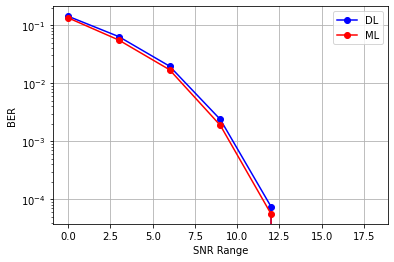

In [ ]:

def frange(x,y,jump):
    while x < y:
        yield x
        x +=jump

EbNodB_range = list(frange(0,21,3))
BER1 = [None]*len(EbNodB_range)


with tf.Session() as sess:
  #Training
    sess.run(init)
    for epoch in range(traing_epochs):
        avg_cost = 0
        for index_m in range(total_batch):
            input_samples = []
            input_samples1 = []
            input_labels = []
            
            for index_k in range(0, batch_size):
                bits1 = np.random.binomial(n=1,p=0.5,size=(q,))
                bits2 = np.random.binomial(n=1,p=0.5,size=(q,))
                signaloutput,y_con,one_hot_bit1,one_hot_bit2 = SC_IM_NO_train(bits1,bits2,20)
                input_labels.append(one_hot_bit1)
                input_samples.append(signaloutput)
                
               

            batch_x = np.asarray(input_samples)
            batch_xx = np.asarray(input_samples1)
            batch_y = np.asarray(input_labels)
           
            
            

            _,cs = sess.run([optimizer,cost], feed_dict={X:batch_x,
                                                        Y:batch_y,
                                                        learning_rate:l_rate})
            avg_cost += cs / total_batch
        if epoch % display_step == 0:
            print("Epoch:",'%04d' % (epoch+1), "cost=", \
               "{:.9f}".format(avg_cost))
#==========Testing=============
    for n in range(0,len(EbNodB_range)):
      input_samples_test = []
      input_samples1_test = []
      input_labels_test = []
      
      test_number = 10000
      if n>3:
        test_number = 10000
      for i in range(0, test_number):
        bits1 = np.random.binomial(n=1, p=0.5, size=(q, )) 
        bits2 = np.random.binomial(n=1, p=0.5, size=(q, ))
        signaloutput,y_con,one_hot_bit1,one_hot_bit2 = SC_IM_NO_train(bits1,bits2,EbNodB_range[n])
        input_labels_test.append(bits1)
        input_samples_test.append(signaloutput)
        
  
  
      batch_1 = np.asarray(input_samples_test)
      batch_2 = np.asarray(input_labels_test)
      one_hot_bit1_est= sess.run(y_pred,feed_dict={X:batch_1})
      bit_error = 0
      for i in range(0, test_number):
        ind_est =np.argmax(one_hot_bit1_est[i,])
        bit_est = detobit(ind_est)
        bit_error =bit_error+sum(bit_est!=batch_2[i,])
      BER1[n] = bit_error/(test_number*q)
    print("SNR=", EbNodB_range[n], "BER:", BER1[n])
    ML1=[0.133100000000000,	0.0551562500000000,	0.0170187500000000,	0.00188125000000000,	5.62500000000000e-05,	0,	0]
    import matplotlib.pyplot as plt
    plt.plot(EbNodB_range, BER1, 'bo-',label='DL')
    plt.plot(EbNodB_range, ML1, 'ro-',label='ML')
    #plt.plot(list(EbNodB_range), ber_theory, 'ro-',label='BPSK BER')
    plt.yscale('log')
    plt.xlabel('SNR Range')
    plt.ylabel('BER')
    plt.grid()
    plt.legend(loc='upper right',ncol = 1)
    #plt.savefig('DL_Detection_IM_BER_matplotlib')
    plt.show()


In [ ]:
BER1

[0.140675, 0.05855, 0.018325, 0.002225, 0.0, 0.0, 0.0]

In [ ]:
X = tf.placeholder("float",[None, 12])
Xa= tf.placeholder("float",[None, 8])
y_pred = encoder(X)
X1 = tf.concat((y_pred,Xa),axis=-1)
Y1 = tf.placeholder("float",[None, 16])
Y2 = tf.placeholder("float",[None, 16])
initializer = tf.contrib.layers.xavier_initializer()

def encoder1(a):
    weights = {
        'encoder_h1': tf.Variable(initializer([24, 480])),
        'encoder_h2': tf.Variable(initializer([480, 960])),
        'encoder_h3': tf.Variable(initializer([960, 16])),
        
    }
    
    biases = {
        'encoder_b1': tf.Variable(initializer([480])),
        'encoder_b2': tf.Variable(initializer([960])),
        'encoder_b3': tf.Variable(initializer([16])),
        
    }
    layer_1 = tf.nn.relu(tf.add(tf.matmul(a, weights['encoder_h1']), biases['encoder_b1']))
    layer_2 = tf.nn.relu(tf.add(tf.matmul(layer_1, weights['encoder_h2']), biases['encoder_b2']))
    layer_3 = tf.nn.softmax(tf.add(tf.matmul(layer_2, weights['encoder_h3']), biases['encoder_b3']))
   
    return layer_3


y2_pred = encoder1(X1)
y2_true = Y2
y_true = Y1

cost = tf.reduce_mean(tf.pow(y2_true - y2_pred,2))


learning_rate = tf.placeholder(tf.float32,shape=[])
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
init = tf.global_variables_initializer()

Epoch: 0001 cost= 0.054807766
Epoch: 0006 cost= 0.005054944
Epoch: 0011 cost= 0.004211917
Epoch: 0016 cost= 0.003826970
Epoch: 0021 cost= 0.002699149
Epoch: 0026 cost= 0.001880243
Epoch: 0031 cost= 0.001450633
Epoch: 0036 cost= 0.001158273
Epoch: 0041 cost= 0.000474710
Epoch: 0046 cost= 0.000206478
Epoch: 0051 cost= 0.000111532
Epoch: 0056 cost= 0.000003433
Epoch: 0061 cost= 0.000002344
Epoch: 0066 cost= 0.000001944
Epoch: 0071 cost= 0.000001579
Epoch: 0076 cost= 0.000001298
Epoch: 0081 cost= 0.000001087
Epoch: 0086 cost= 0.000000970
Epoch: 0091 cost= 0.000000845
Epoch: 0096 cost= 0.000000725
Epoch: 0101 cost= 0.000000711
Epoch: 0106 cost= 0.000000570
Epoch: 0111 cost= 0.000000546
Epoch: 0116 cost= 0.000000482
Epoch: 0121 cost= 0.000000449
Epoch: 0126 cost= 0.000000421
Epoch: 0131 cost= 0.000000366
Epoch: 0136 cost= 0.000000352
Epoch: 0141 cost= 0.000000314
Epoch: 0146 cost= 0.000000299
Epoch: 0151 cost= 0.000000268
Epoch: 0156 cost= 0.000000244
Epoch: 0161 cost= 0.000000229
Epoch: 016

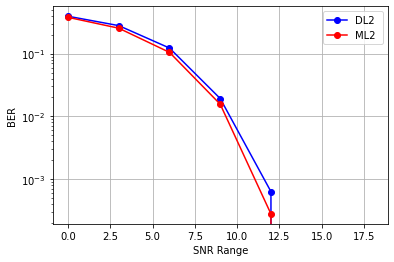

In [ ]:
def frange(x,y,jump):
    while x < y:
        yield x
        x +=jump

EbNodB_range = list(frange(0,21,3))
BER1 = [None]*len(EbNodB_range)
BER2 = [None]*len(EbNodB_range)


with tf.Session() as sess:
  #Training
    sess.run(init)
    for epoch in range(traing_epochs):
        avg_cost = 0
        for index_m in range(total_batch):
            input_samples = []
            input_samples1 = []
            input_labels  = []
            input_labels1 = []
            

            
            for index_k in range(0, batch_size):
                bits1 = np.random.binomial(n=1,p=0.5,size=(q,))
                bits2 = np.random.binomial(n=1,p=0.5,size=(q,))
                signaloutput,y_con,one_hot_bit1,one_hot_bit2 = SC_IM_NO_train(bits1,bits2,20)
                input_samples.append(signaloutput)
                input_samples1.append(y_con)
                input_labels.append(one_hot_bit1)
                input_labels1.append(one_hot_bit2)
                

            batch_1 = np.asarray(input_samples)
            batch_2 = np.asarray(input_samples1)
            batch_3 = np.asarray(input_labels)
            batch_4 = np.asarray(input_labels1)
            
            
           
            
            

            _,cs = sess.run([optimizer,cost], feed_dict={X:batch_1,Xa:batch_2,
                                                        Y1:batch_3,Y2:batch_4,
                                                        learning_rate:l_rate})
            avg_cost += cs / total_batch
        if epoch % display_step == 0:
            print("Epoch:",'%04d' % (epoch+1), "cost=", \
               "{:.9f}".format(avg_cost))
  #==========Testing=============
    for n in range(0,len(EbNodB_range)):
      input_samples_test = []
      input_samples1_test = []
      input_labels_test = []
      input_labels1_test = []
      
      test_number = 10000
      if n>10:
        test_number = 10000
      for i in range(0, test_number):
        bits1 = np.random.binomial(n=1, p=0.5, size=(q, )) 
        bits2 = np.random.binomial(n=1, p=0.5, size=(q, ))
        signaloutput,y_con,one_hot_bit1,one_hot_bit2 = SC_IM_NO_train(bits1,bits2,EbNodB_range[n])
        input_samples_test.append(signaloutput)
        input_samples1_test.append(y_con)
        input_labels_test.append(bits1)
        input_labels1_test.append(bits2)
       
               

      batch_x = np.asarray(input_samples_test)
      batch_y = np.asarray(input_samples1_test)
      batch_z = np.asarray(input_labels_test)
      batch_t = np.asarray(input_labels1_test)
      one_hot_bit2_est = sess.run(y2_pred,feed_dict={X:batch_x,Xa:batch_y})
      bit_error1 = 0
      for i in range(0, test_number):
        ind_est =np.argmax(one_hot_bit2_est[i,])
        bit_est = detobit(ind_est)
        bit_error1 =bit_error1+sum(bit_est!=batch_t[i,])
      BER2[n] = bit_error1/(test_number*q)
    print("SNR=", EbNodB_range[n], "BER:", BER2[n])
      
      
     
      
     
    
    
    ML2=[0.382100000000000,	0.255943750000000,	0.105200000000000	,0.0155937500000000	,0.000275000000000000,	0,	0]
    import matplotlib.pyplot as plt
    plt.plot(EbNodB_range, BER2, 'bo-',label='DL2 ')
    plt.plot(EbNodB_range, ML2, 'ro-',label='ML2 ')
    #plt.plot(list(EbNodB_range), ber_theory, 'ro-',label='BPSK BER')
    plt.yscale('log')
    plt.xlabel('SNR Range')
    plt.ylabel('BER')
    plt.grid()
    plt.legend(loc='upper right',ncol = 1)
    #plt.savefig('DL_Detection_IM_BER_matplotlib')
    plt.show()

In [ ]:
BER2

[0.39755, 0.281475, 0.123325, 0.019225, 0.000625, 0.0, 0.0]